# POMDP Mazes
In this notebook, we will show off the power of POMDPs using mazes.
The idea is that you start on some tile, without knowing which tile. You can walk in four directions. If you run into a wall, you observe this. Based on this you can determine where in the maze you are and escape.

In [1]:
import stormvogel.model
from stormvogel.model import EmptyAction
from stormvogel.layout import Layout
from stormvogel.show import show

In [2]:
# HERE FOR DEVELOPMENT, MOVE TO LIB
import matplotlib
from matplotlib import pyplot as plt

WALL_SYM = "X"
EMPTY_SYM = "."
EXIT_SYM = "O"

def parse_level(level):
    d = {EXIT_SYM: 2, WALL_SYM: 1, EMPTY_SYM: 0}
    level_list = list(filter(lambda x: x != "", level.splitlines()))
    level_list = list(map(
        lambda x: list(map(lambda y: d[y], x)), 
        level_list))
    width = len(level_list[0])
    height = len(level_list)
    return (level_list, width, height)


def show_grid(level, hor_size):
    # https://stackoverflow.com/questions/19586828/drawing-grid-pattern-in-matplotlib
    level_list, width, height = parse_level(level)
        
    # make a figure + axes
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    fig.set_size_inches(hor_size, hor_size)
    # make color map
    my_cmap = matplotlib.colors.ListedColormap(['#8FCB9B', '#8F8073', '#0096FF'])
    # draw the grid
    for x in range(width + 1):
        ax.axvline(x, lw=2, color='k', zorder=5)
    for y in range(height + 1):
        ax.axhline(y, lw=2, color='k', zorder=5)
    
    # draw the boxes
    ax.imshow(level_list, interpolation='none', cmap=my_cmap, extent=[0, width, 0, height], zorder=0, )
    # turn off the axis labels
    ax.axis('off')

END = 4
EXIT = 2
WALL = 1
WALKABLE = 0
OUT_OF_BOUNDS = -1
UNKNOWN = 3

LEFT = "←"
RIGHT = "→"
UP = "↑"
DOWN = "↓"

def out_of_bounds(x, y, width, height):
    return x < 0 or y < 0 or x > width-1 or y > height -1

def direction_result(x: int, y: int, direction: str, level_list: list, width: int, height: int):
    d = {UP: (0,-1), RIGHT: (1,0), DOWN: (0,1), LEFT:(-1,0)}
    res_x = x + d[direction][0]
    res_y = y + d[direction][1]
    if out_of_bounds(res_x,res_y,width,height):
        return ((res_x,res_y), OUT_OF_BOUNDS)
    if level_list[res_y][res_x] == WALL:
        return ((x,y), WALL)
    else:
        return ((res_x, res_y), WALKABLE)

def grid_world(level:list, position_scalar:int=200):
    """Create a grid world with an actor."""
    level_list, width, height = parse_level(level)
    pomdp = stormvogel.model.new_pomdp(create_initial_state=False)
    reward_model = pomdp.add_rewards("")
    
    escaped = pomdp.new_state("escaped")
    escaped.set_observation(END)
    #reward_model.set(escaped, 0)
    
    grid = [[None for x in range(width)] for y in range(height)]
    for x in range(width):
        for y in range(height):
            if level_list[y][x] == WALKABLE:
                grid[y][x] = pomdp.new_state(["t", f"({x},{y})"])
                grid[y][x].set_observation(UNKNOWN)
                #reward_model.set_state_action_reward(grid[y][x], -1)
            if level_list[y][x] == EXIT:
                grid[y][x] = pomdp.new_state(["e", f"({x},{y})"])
                grid[y][x].set_observation(UNKNOWN)
                #reward_model.set_state_action_reward(grid[y][x], 100)
                grid[y][x].add_transitions([(1, escaped)])
    dirs = {d: pomdp.new_action(d) for d in [UP, DOWN, LEFT, RIGHT]}
    positions = {}
    # Add movement
    for x in range(width):
        for y in range(height):
            if level_list[y][x] == WALKABLE:
                for d,action in dirs.items():
                    positions[str(grid[y][x].id)] = {"x": x * position_scalar, "y": y * position_scalar}
                    ((res_x, res_y), observation) = direction_result(x,y,d,level_list,width,height)

                    
                    
                    if not observation == OUT_OF_BOUNDS:
                        took_dir = pomdp.new_state([d, f"({x},{y})"])
                        grid[y][x].add_transitions([(action, took_dir)])
                        #reward_model.set_state_action_reward(grid[y][x], action, -1)
                        # print(took_dir)
                        took_dir.add_transitions([(1, grid[res_y][res_x])])
                        reward_model.set_state_action_reward(took_dir, EmptyAction, -1)
                        took_dir.set_observation(observation)
    pomdp.add_self_loops()
    reward_model.set_unset_rewards(0)
    return pomdp, positions

First, we define a simple maze in ASSCI. 'X' are walls, '.' are walkable tiles, 'O' is the exit. We visualize it as a grid where walls are brown, walkable tiles are green, and the exit is blue.

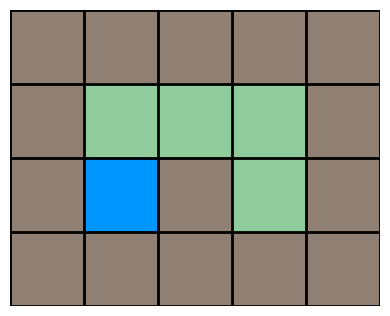

In [3]:
LEVEL ="""
XXXXX
X...X
XOX.X
XXXXX
"""

show_grid(LEVEL, hor_size=4)

Now we create a POMDP from the level. Can you see how it corresponds to the maze?

In [4]:
pomdp, positions = grid_world(LEVEL)

vis = show(pomdp, layout=Layout("layouts/grid.json"))

Some things to keep in mind.
* The tiles in the grid that aren't walls have a state t,(x,y)
* From such a tile, you can try to go left, right, top or bottom (these are actions)
* After taking an action, you go to a state with an observation (symbol ⊙). After this you proceed to another tile state.
    + If you try to go into a wall, you observe that you hit a wall (1)
    + If you do not hit a wall, you observe this as well (0)
* Every state has a reward according to our reward model (euro sign). Solving the maze will give you 100 reward but taking a step will cost 1.

For example, if you try to go left in tile (3,2), you observe that you hit a wall and you go back to (3,2). However, if you try to go up, you observe that you don't hit a wall and proceed to (3,1).

In [5]:
from stormvogel.mapping import stormvogel_to_stormpy, stormpy_to_stormvogel

stormpy_model = stormvogel_to_stormpy(pomdp)
print(stormpy_model)
pomdp2 = stormpy_to_stormvogel(stormpy_model)
#vis2 = show(pomdp2, layout=Layout("layouts/grid.json"))


# TODO use the stormvogel model checking instead!
# TODO fix the layout once we switch to sets for displaying labels

-------------------------------------------------------------- 
Model type: 	POMDP (sparse)
States: 	22
Transitions: 	34
Choices: 	34
Observations: 	5
Reward Models:  (default)
State Labels: 	12 labels
   * (3,2) -> 5 item(s)
   * (1,2) -> 1 item(s)
   * (2,1) -> 5 item(s)
   * (1,1) -> 5 item(s)
   * ← -> 4 item(s)
   * escaped -> 1 item(s)
   * (3,1) -> 5 item(s)
   * ↓ -> 4 item(s)
   * ↑ -> 4 item(s)
   * t -> 4 item(s)
   * e -> 1 item(s)
   * → -> 4 item(s)
Choice Labels: 	4 labels
   * ↓ -> 4 item(s)
   * ← -> 4 item(s)
   * → -> 4 item(s)
   * ↑ -> 4 item(s)
-------------------------------------------------------------- 

